# COURSE: A deep understanding of deep learning
## SECTION: More on data
### LECTURE: Saving and loading trained models
#### TEACHER: Mike X Cohen, sincxpress.com
##### COURSE URL: udemy.com/course/deeplearning_x/?couponCode=202401

In [1]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# Import and process the data

In [8]:
import torchvision
MNIST = torchvision.datasets.MNIST(".", download=True)
data = MNIST.train_data
labels = MNIST.train_labels

data = data.view(data.shape[0], -1).numpy()
labels = labels.numpy()
indices = np.random.choice(data.shape[0], 20000, replace=False)
data = data[indices]
labels = labels[indices]

In [9]:
# import dataset (comes with colab!)
#data = np.loadtxt(open('sample_data/mnist_train_small.csv','rb'),delimiter=',')

# extract labels (number IDs) and remove from data
#labels = data[:,0]
#data   = data[:,1:]

# normalize the data to a range of [0 1]
dataNorm = data / np.max(data)

# Create train/test groups using DataLoader

In [10]:
# Step 1: convert to tensor
dataT   = torch.tensor( dataNorm ).float()
labelsT = torch.tensor( labels ).long()

# Step 2: use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labelsT, test_size=.1)


# Step 3: convert into PyTorch Datasets
train_data = torch.utils.data.TensorDataset(train_data,train_labels)
test_data  = torch.utils.data.TensorDataset(test_data,test_labels)

# Step 4: translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

# Create the DL model

In [11]:
# create a class for the model
def createTheMNISTNet():

  class mnistNet(nn.Module):
    def __init__(self):
      super().__init__()

      ### input layer
      self.input = nn.Linear(784,64)
      
      ### hidden layer
      self.fc1 = nn.Linear(64,32)
      self.fc2 = nn.Linear(32,32)

      ### output layer
      self.output = nn.Linear(32,10)

    # forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      x = F.relu( self.fc1(x) )
      x = F.relu( self.fc2(x) )
      return torch.log_softmax( self.output(x),axis=1 )
      # NEW HERE: log-softmax the output, because I'm using NLLLoss instead of CrossEntropyLoss
  
  # create the model instance
  net = mnistNet()
  
  # loss function
  lossfun = nn.NLLLoss()

  # optimizer
  optimizer = torch.optim.SGD(net.parameters(),lr=.01)

  return net,lossfun,optimizer

# Create a function that trains the model

In [12]:
# a function that trains the model

def function2trainTheModel():

  # number of epochs
  numepochs = 10
  
  # create a new model
  net,lossfun,optimizer = createTheMNISTNet()

  # initialize losses
  losses    = torch.zeros(numepochs)
  trainAcc  = []
  testAcc   = []


  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    yHat = net(X)
      
    # compare the following really long line of code to the training accuracy lines
    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )

  # end epochs

  # function output
  return trainAcc,testAcc,losses,net


# Run the model and show the results!

In [13]:
trainAcc,testAcc,losses,net = function2trainTheModel()

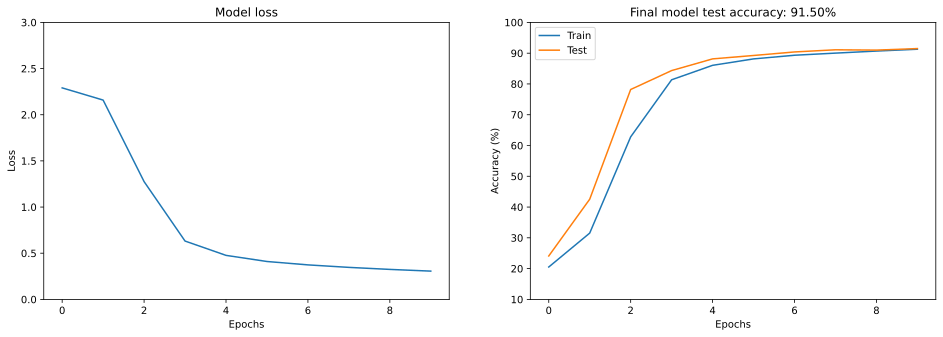

In [14]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0,3])
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,label='Train')
ax[1].plot(testAcc,label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim([10,100])
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

# Save the trained model

In [15]:
net.state_dict()

OrderedDict([('input.weight',
              tensor([[ 0.0030, -0.0077, -0.0329,  ..., -0.0190, -0.0239,  0.0126],
                      [-0.0133, -0.0080,  0.0057,  ..., -0.0112, -0.0264, -0.0341],
                      [-0.0002,  0.0193, -0.0278,  ..., -0.0071, -0.0165,  0.0083],
                      ...,
                      [ 0.0322,  0.0086,  0.0249,  ..., -0.0201, -0.0153, -0.0083],
                      [ 0.0339,  0.0185,  0.0281,  ...,  0.0026, -0.0284,  0.0227],
                      [-0.0058, -0.0064, -0.0323,  ..., -0.0283,  0.0094, -0.0207]])),
             ('input.bias',
              tensor([-0.0172,  0.0122,  0.0378,  0.0325,  0.0398,  0.0254,  0.0693,  0.1131,
                      -0.0055, -0.0360,  0.0031,  0.0517,  0.0285,  0.0423,  0.0746,  0.0750,
                      -0.0073,  0.0402,  0.0018, -0.0208,  0.0645,  0.0991, -0.0165, -0.0501,
                       0.0270,  0.0400, -0.0158,  0.0554,  0.0354,  0.0385,  0.0159,  0.0133,
                       0.0593,  

In [16]:
# save the model
torch.save(net.state_dict(),'trainedModel.pt')

# Load in the model under a different name

In [17]:
# create two new models of the same class
model1 = createTheMNISTNet()[0]
model2 = createTheMNISTNet()[0]

# replace one model's parameters with those of the trained net
model1.load_state_dict(torch.load('trainedModel.pt'))

C:\Users\pmiha\AppData\Local\Temp\ipykernel_11988\864876627.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model1.load_state_dict(torch.load('trainedModel.pt'))


<All keys matched successfully>

# Show that the two models are the same

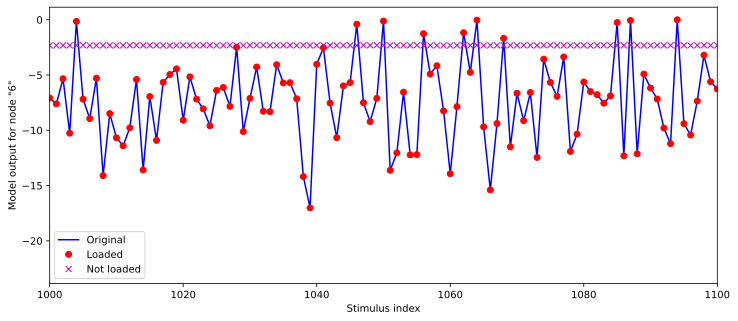

In [18]:
# get some data from the test loader
X,y = next(iter(test_loader))

# run the data through both models
yHatNet    = net(X)
yHatModel1 = model1(X)
yHatModel2 = model2(X)


# show that the results overlap
fig = plt.figure(figsize=(12,5))
plt.plot(yHatNet[:,5].detach(),'b',label='Original')
plt.plot(yHatModel1[:,5].detach(),'ro',label='Loaded')
plt.plot(yHatModel2[:,5].detach(),'mx',label='Not loaded')
plt.legend()
plt.xlabel('Stimulus index')
plt.ylabel('Model output for node "6"')
plt.xlim([1000,1100])

plt.show()